In [1]:
%run ../setup/nb_setup
%matplotlib inline

# Compute a Galactic orbit for a star using Gaia data

Author(s): Adrian Price-Whelan


## Learning goals

In this tutorial, we will retrieve the sky coordinates, astrometry, and radial velocity for a star — [Kepler-444](https://en.wikipedia.org/wiki/Kepler-444) — and compute its orbit in the default Milky Way mass model implemented in Gala. We will compare the orbit of Kepler-444 to the orbit of the Sun and a random sample of nearby stars.


## Introduction

TODO


## Terminology and Notation

- TODO


### Notebook Setup and Package Imports

In [2]:
import astropy.coordinates as coord
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
from pyia import GaiaData

# Gala
import gala.dynamics as gd
import gala.potential as gp

## Define a Galactocentric Coordinate Frame

We will start by defining a Galactocentric coordinate system using `astropy.coordinates` by adopting the latest parameter set for the Solar position and velocity with respect to the Galactic Center implemented in Astropy.

In [3]:
with coord.galactocentric_frame_defaults.set('v4.0'):
    galcen_frame = coord.Galactocentric()
galcen_frame

<Galactocentric Frame (galcen_coord=<ICRS Coordinate: (ra, dec) in deg
    (266.4051, -28.936175)>, galcen_distance=8.122 kpc, galcen_v_sun=(12.9, 245.6, 7.78) km / s, z_sun=20.8 pc, roll=0.0 deg)>

## Define the Solar Position and Velocity

In this coordinate system, the sun is along the $x$-axis (at a negative $x$ value), and the Galactic rotation at this position is in the $+y$ direction. In this coordinate system, the 3D position of the sun is therefore given by:

In [4]:
sun_xyz = u.Quantity([
    - galcen_frame.galcen_distance,  # x
    0*u.kpc,  # y
    galcen_frame.z_sun  # z
])

We can combine this with the solar velocity vector (set on the `astropy.coordinates.Galactocentric` frame) to define the sun's phase-space position, which we will use as initial conditions shortly to compute the orbit of the Sun:

In [5]:
sun_w0 = gd.PhaseSpacePosition(
    pos=sun_xyz,
    vel=galcen_frame.galcen_v_sun
)

To compute the sun's orbit, we need to specify a mass model for the Galaxy. Here, we will use the default Milky Way mass model implemented in Gala, which is defined in detail in the Gala documentation: [Defining a Milky Way model](define-milky-way-model.html). Here, we will initialize the potential model with default parameters:

In [6]:
mw_potential = gp.MilkyWayPotential()
mw_potential

<CompositePotential disk,bulge,nucleus,halo>

This potential is composed of four mass components meant to represent simple models of the different structural components of the Milky Way:

In [7]:
for k, pot in mw_potential.items():
    print(f"{k}: {pot!r}")

disk: <MiyamotoNagaiPotential: m=6.80e+10, a=3.00, b=0.28 (kpc,Myr,solMass,rad)>
bulge: <HernquistPotential: m=5.00e+09, c=1.00 (kpc,Myr,solMass,rad)>
nucleus: <HernquistPotential: m=1.71e+09, c=0.07 (kpc,Myr,solMass,rad)>
halo: <NFWPotential: m=5.40e+11, r_s=15.62, a=1.00, b=1.00, c=1.00 (kpc,Myr,solMass,rad)>


With a potential model for the Galaxy and initial conditions for the sun, we can now compute the Sun's orbit using the default integrator (Leapfrog integration): We will compute the orbit for 4 Gyr, which is about 16 orbital periods.

In [8]:
sun_orbit = mw_potential.integrate_orbit(
    sun_w0, dt=0.5*u.Myr, t1=0, t2=4*u.Gyr)

## Retrieve Gaia Data for Kepler-444

For our comparison star, we will use the exoplanet-hosting star Kepler-444. To get Gaia data for this source, we first have to retrieve its sky coordinates so that we can do a positional cross-match query on the Gaia catalog. We can retrieve the sky position of Kepler-444 using the `SkyCoord.from_name()` classmethod, which queries Simbad under the hood to resolve the name:

In [9]:
star_sky_c = coord.SkyCoord.from_name('Kepler-444')
star_sky_c

<SkyCoord (ICRS): (ra, dec) in deg
    (289.75228683, 41.63460601)>

We happen to know a priori that Kepler-444 has a large proper motion, so the sky position reported by Simbad (unknown epoch) could be off from the Gaia sky position (epoch=2016) by many arcseconds. To run and retrieve the Gaia data, we will use the [pyia](http://pyia.readthedocs.io/) package: We can pass in an ADQL query, which `pyia` uses to query the Gaia science archive using `astroquery`, and returns the data as a `pyia` object that understands how to convert the Gaia data columns into a `astropy.coordinates.SkyCoord` object. To run the query, we will do a large sky position cross-match (with a radius of 15 arcseconds), and take the brightest cross-matched source within this region:

In [10]:
star_gaia = GaiaData.from_query(
    f"""
    SELECT TOP 1 * FROM gaiaedr3.gaia_source
    WHERE 1=CONTAINS(
        POINT('ICRS', {star_sky_c.ra.degree}, {star_sky_c.dec.degree}),
        CIRCLE('ICRS', ra, dec, {(15*u.arcsec).to_value(u.degree)})
    )
    ORDER BY phot_g_mean_mag
    """
)
star_gaia

Created TAP+ (v20200428.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v20200428.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
INFO: Query finished. [astroquery.utils.tap.core]


<GaiaData: 1 rows>

We will assume (and hope!) that this source is Kepler-444, but we know that it is fairly bright compared to a typical Gaia source, so we should be safe.

We can now use the returned `pyia.GaiaData` object to convert the Gaia astrometric and radial velocity measurements into an Astropy `SkyCoord` object (with all position and velocity data):

In [11]:
star_gaia_c = star_gaia.get_skycoord()
star_gaia_c

<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, pc)
    [(289.75284986, 41.63179615, 36.55263772)]
 (pm_ra_cosdec, pm_dec, radial_velocity) in (mas / yr, mas / yr, km / s)
    [(94.63943807, -632.26859246, -121.817696)]>

To compute this star's Galactic orbit, we need to convert its observed, Heliocentric (actually solar system barycentric) data into the Galactocentric coordinate frame we defined above. To do this, we will use the `astropy.coordinates` transformation framework:

In [12]:
star_galcen = star_gaia_c.transform_to(galcen_frame)
star_galcen

<SkyCoord (Galactocentric: galcen_coord=<ICRS Coordinate: (ra, dec) in deg
    (266.4051, -28.936175)>, galcen_distance=8.122 kpc, galcen_v_sun=(12.9, 245.6, 7.78) km / s, z_sun=20.8 pc, roll=0.0 deg): (x, y, z) in pc
    [(-8111.74969996, 34.13942928, 28.92842808)]
 (v_x, v_y, v_z) in km / s
    [(71.08824865, 118.44310227, -79.14841969)]>

Now with Galactocentric position and velocity components for Kepler-444, we can create Gala initial conditions and compute its orbit on the time grid used to compute the Sun's orbit above:

In [13]:
star_w0 = gd.PhaseSpacePosition(star_galcen.data)
star_orbit = mw_potential.integrate_orbit(
    star_w0, t=sun_orbit.t)

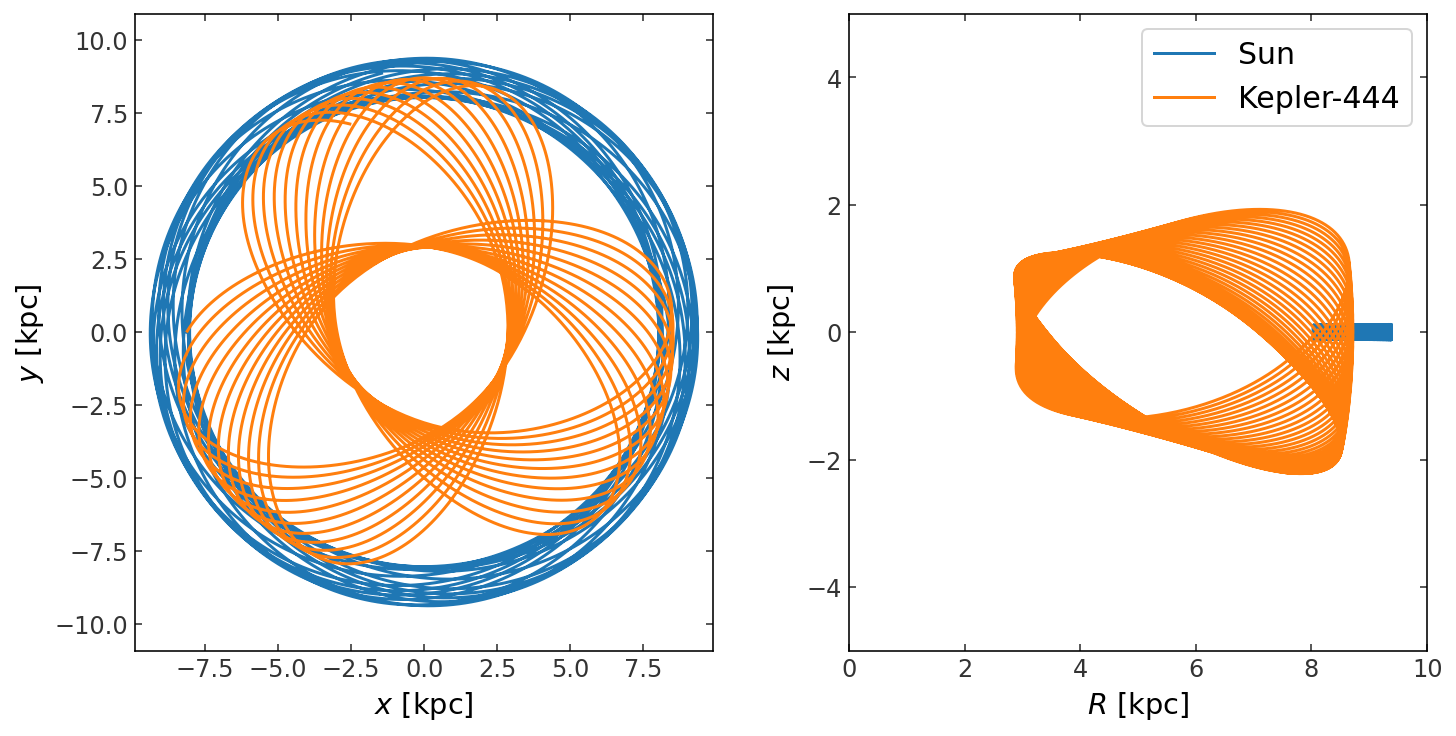

In [14]:
fig, axes = plt.subplots(
    1, 2,
    figsize=(10, 5), 
    constrained_layout=True
)

sun_orbit.plot(['x', 'y'], axes=axes[0])
star_orbit.plot(['x', 'y'], axes=axes[0])
axes[0].set_xlim(-10, 10)
axes[0].set_ylim(-10, 10)

sun_orbit.cylindrical.plot(['rho', 'z'], 
                           axes=axes[1], 
                           auto_aspect=False, 
                           labels=['$R$ [kpc]', '$z$ [kpc]'],
                           label='Sun')
star_orbit.cylindrical.plot(['rho', 'z'], 
                            axes=axes[1], 
                            auto_aspect=False, 
                            labels=['$R$ [kpc]', '$z$ [kpc]'],
                            label='Kepler-444')
axes[1].set_xlim(0, 10)
axes[1].set_ylim(-5, 5)
axes[1].set_aspect('auto')
axes[1].legend(loc='best', fontsize=15)

### Exercise: How does Kepler-444's orbit differ from the Sun's?

What are the guiding center radii of the two orbits? What is the maximum $z$ height reached by each orbit? What are their eccentricities? Can you guess which star is older based on their kinematics? Which star do you think has a higher metallicity?

### Exercise: Comparing these orbits to the orbits of other Gaia stars

Retrieve Gaia data for a set of 100 random Gaia stars within 200 pc of the sun with measured radial velocities and well-measured parallaxes using the query:

    SELECT TOP 100 * FROM gaiaedr3.gaia_source 
        WHERE dr2_radial_velocity IS NOT NULL AND
            parallax_over_error > 10 AND
            ruwe < 1.2 AND
            parallax > 5
        ORDER BY random_index

In [15]:
random_stars_g = GaiaData.from_query(
    """
    SELECT TOP 100 * FROM gaiaedr3.gaia_source 
    WHERE dr2_radial_velocity IS NOT NULL AND
        parallax_over_error > 10 AND
        ruwe < 1.2 AND
        parallax > 5
    ORDER BY random_index
    """
)

INFO: Query finished. [astroquery.utils.tap.core]


Compute orbits for these stars for the same time grid used above to compute the sun's orbit:

In [16]:
random_stars_c = random_stars_g.get_skycoord()

In [17]:
random_stars_galcen = random_stars_c.transform_to(galcen_frame)
random_stars_w0 = gd.PhaseSpacePosition(random_stars_galcen.data)

In [18]:
random_stars_orbits = mw_potential.integrate_orbit(
    random_stars_w0, t=sun_orbit.t)

Plot the initial (present-day) positions of all of these stars in Galactocentric Cartesian coordinates:

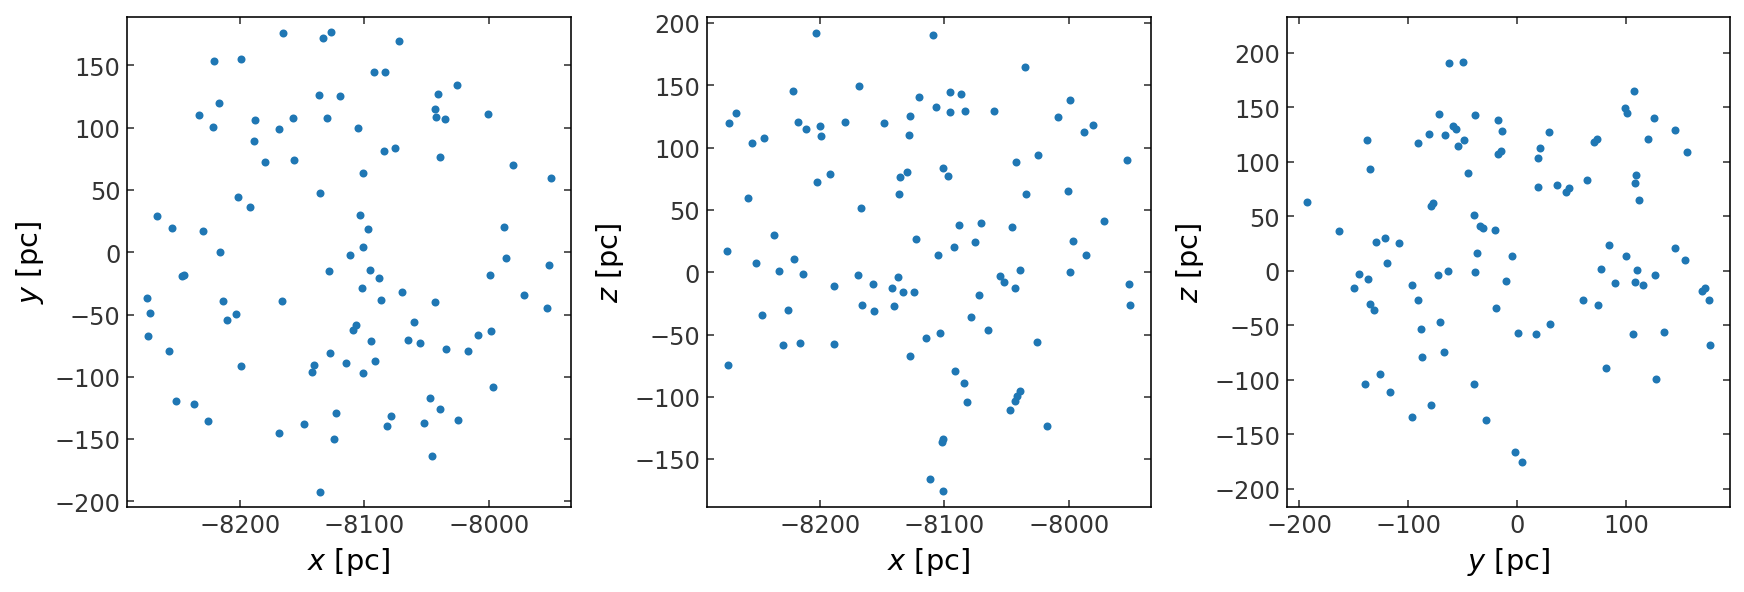

In [19]:
_ = random_stars_w0.plot()

Now plot the orbits of these stars in the x-y and R-z planes:

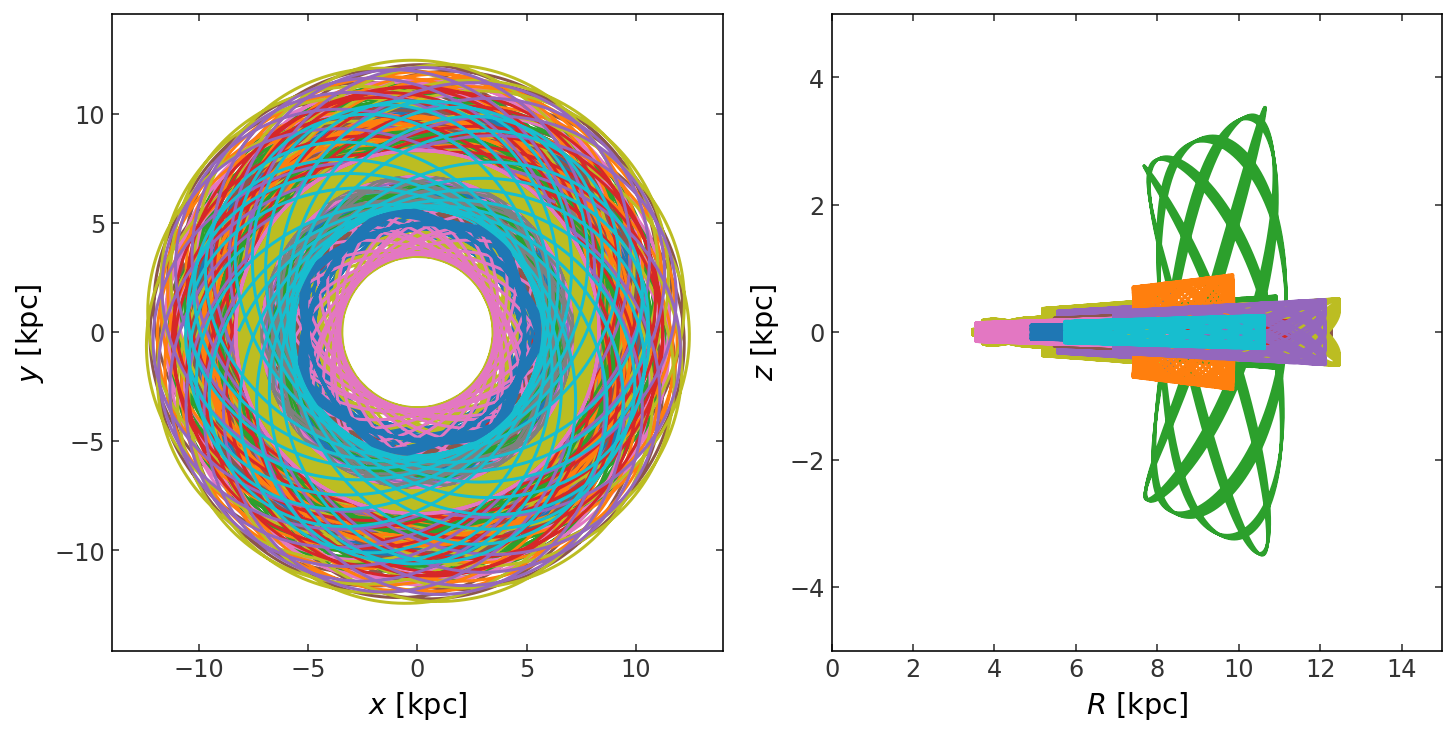

In [20]:
fig, axes = plt.subplots(
    1, 2,
    figsize=(10, 5), 
    constrained_layout=True
)

random_stars_orbits.plot(['x', 'y'], axes=axes[0])
axes[0].set_xlim(-15, 15)
axes[0].set_ylim(-15, 15)

random_stars_orbits.cylindrical.plot(
    ['rho', 'z'], 
    axes=axes[1], 
    auto_aspect=False, 
    labels=['$R$ [kpc]', '$z$ [kpc]'],
)

axes[1].set_xlim(0, 15)
axes[1].set_ylim(-5, 5)
axes[1].set_aspect('auto')

Compute maximum $z$ heights ($z_\textrm{max}$) and eccentricities for all of these orbits. Compare the Sun, Kepler-444, and this random sampling of nearby stars. Where do the Sun and Kepler-444 sit relative to the random sample of nearby stars in terms of $z_\textrm{max}$ and eccentricity? (Hint: plot $z_\textrm{max}$ vs. eccentricity and highlight the Sun and Kepler-444!) Are either of them outliers in any way?

In [21]:
rand_zmax = random_stars_orbits.zmax()

In [22]:
rand_ecc = random_stars_orbits.eccentricity()

Text(0, 0.5, 'max. $z$ height, $z_{\\rm max}$ [kpc]')

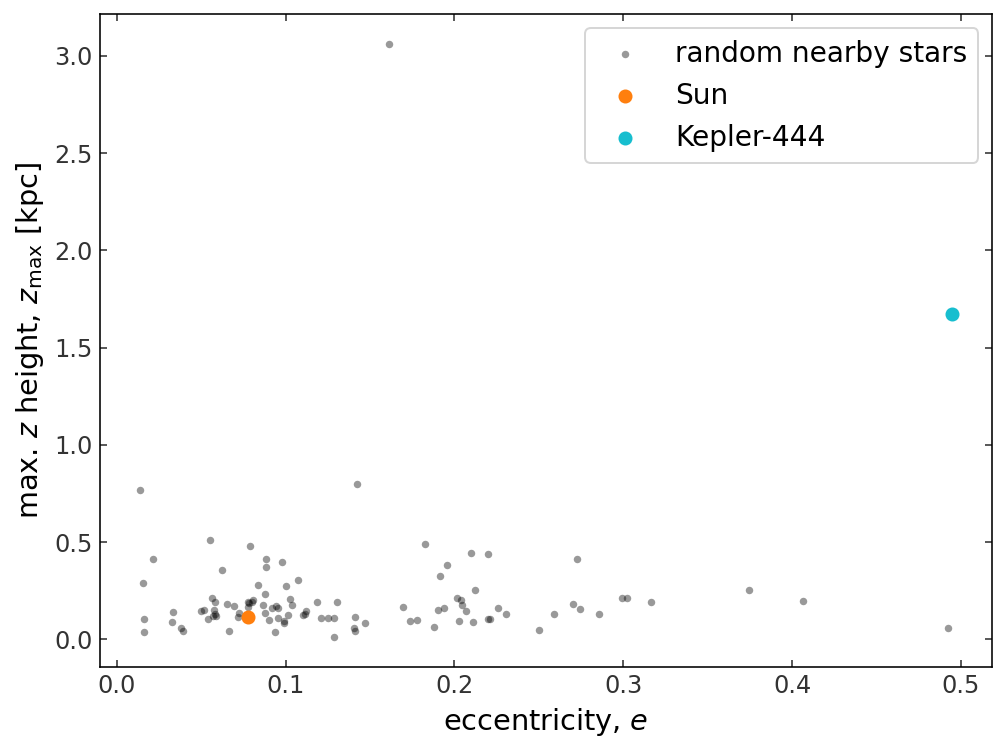

In [23]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(rand_ecc, rand_zmax, 
           color='k', alpha=0.4, s=14, lw=0,
           label='random nearby stars')
ax.scatter(sun_orbit.eccentricity(), sun_orbit.zmax(), 
           color='tab:orange', 
           label='Sun')
ax.scatter(star_orbit.eccentricity(), star_orbit.zmax(), 
           color='tab:cyan',
           label='Kepler-444')
ax.legend(loc='best', fontsize=14)
ax.set_xlabel('eccentricity, $e$')
ax.set_ylabel(r'max. $z$ height, $z_{\rm max}$ [kpc]')